In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
file = 'default of credit card clients.xls'

df = pd.read_excel(file)

# Drop the first column from the DataFrame
df.drop(df.columns[0], axis=1, inplace=True)

# Replace the column names with the values from the second row
new_column_names = df.iloc[0]
df.columns = new_column_names

# Resetting the index
df = df.iloc[1:].reset_index(drop=True)

df = df.rename(columns={"default payment next month": "Y"})

# Display the DataFrame with the updated column names
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
count,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,...,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
unique,81,2,7,4,56,11,11,11,11,10,...,21548,21010,20604,7943,7899,7518,6937,6897,6939,2
top,50000,2,2,2,29,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,3365,18112,14030,15964,1605,14737,15730,15764,16455,16947,...,3195,3506,4020,5249,5396,5968,6408,6703,7173,23364


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LIMIT_BAL  30000 non-null  object
 1   SEX        30000 non-null  object
 2   EDUCATION  30000 non-null  object
 3   MARRIAGE   30000 non-null  object
 4   AGE        30000 non-null  object
 5   PAY_0      30000 non-null  object
 6   PAY_2      30000 non-null  object
 7   PAY_3      30000 non-null  object
 8   PAY_4      30000 non-null  object
 9   PAY_5      30000 non-null  object
 10  PAY_6      30000 non-null  object
 11  BILL_AMT1  30000 non-null  object
 12  BILL_AMT2  30000 non-null  object
 13  BILL_AMT3  30000 non-null  object
 14  BILL_AMT4  30000 non-null  object
 15  BILL_AMT5  30000 non-null  object
 16  BILL_AMT6  30000 non-null  object
 17  PAY_AMT1   30000 non-null  object
 18  PAY_AMT2   30000 non-null  object
 19  PAY_AMT3   30000 non-null  object
 20  PAY_AMT4   30000 non-null  o

In [5]:
# Check for missing values in the DataFrame
df.isnull().sum()

0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

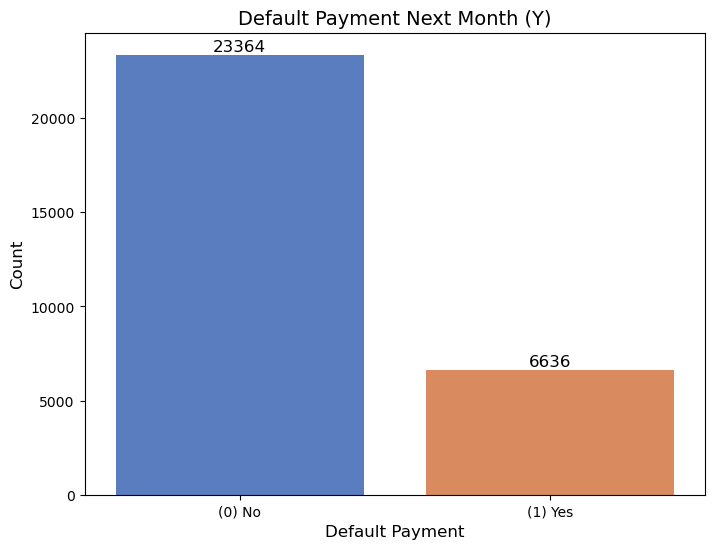

In [6]:
# Count of each class in 'Y' column
y_counts = df['Y'].value_counts()

plt.figure(figsize=(8,6))  # Set the figure size
sns.barplot(x=y_counts.index, y=y_counts.values, palette="muted")  # Create a barplot

plt.title('Default Payment Next Month (Y)', fontsize=14)  # Set the title and its fontsize
plt.xlabel('Default Payment', fontsize=12)  # Set x-axis label and its fontsize
plt.ylabel('Count', fontsize=12)  # Set y-axis label and its fontsize

# Annotate the heights of bars for better visual understanding
for i, v in enumerate(y_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

plt.xticks(ticks=[0, 1], labels=['(0) No', '(1) Yes'])  # Replace 0,1 labels with No and Yes for better understanding
plt.show()

In [7]:
# Identify categorical and numerical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
numeric_cols = df.columns.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', "Y"]).tolist()

df[numeric_cols] = df[numeric_cols].astype(int)

df[cat_cols] = df[cat_cols].astype(int)

df['Y'] = df['Y'].astype(int)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

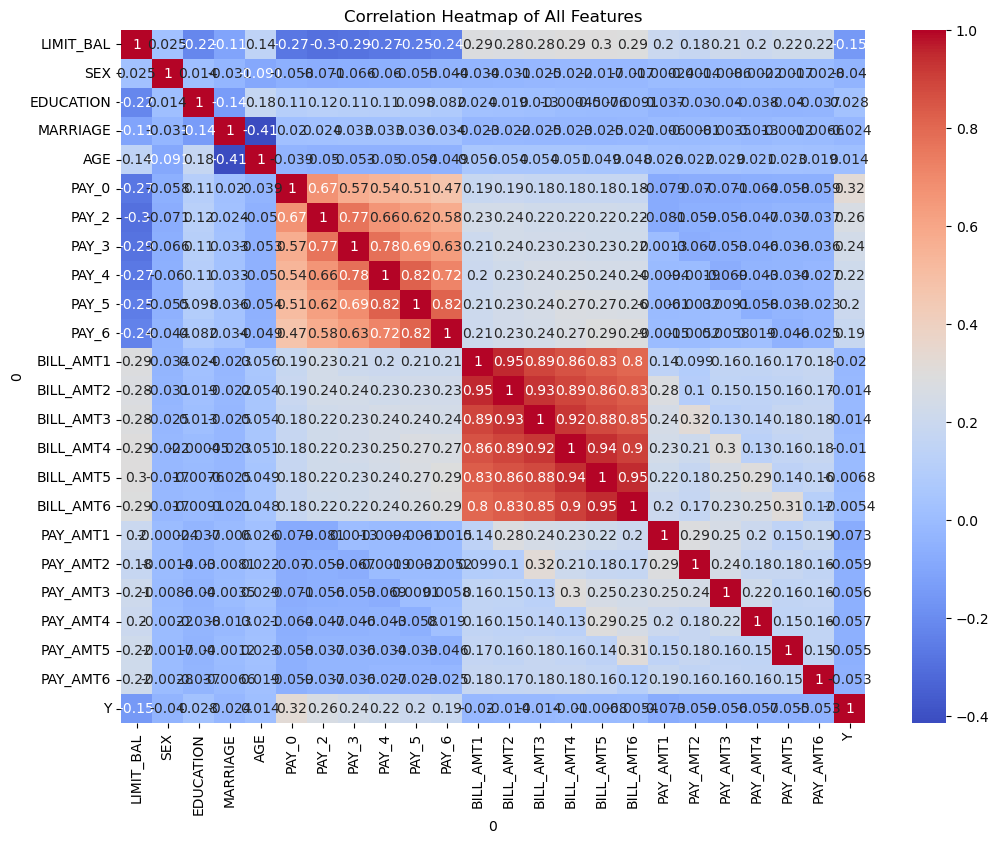

In [9]:
# Compute correlation matrix for all features
correlation_matrix = df.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap of All Features')
plt.show()

In [12]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Support Vector Machines': LinearSVC(max_iter=10000, C=10),
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(sparse_output=False), cat_cols)])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('Y', axis=1), df['Y'], test_size=0.2, random_state=42)

# Convert y_train and y_test to integer
y_train = y_train.astype('int')
y_test = y_test.astype('int')

for model_name, model in models.items():
    X_train_temp = X_train.copy()
    y_train_temp = y_train.copy()
    X_test_temp = X_test.copy()
    y_test_temp = y_test.copy()

    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               (model_name, model)])

    # Fit the model
    pipeline.fit(X_train_temp, y_train_temp)

    # Make predictions
    y_pred = pipeline.predict(X_test_temp)

    # Print accuracy
    print(f'Accuracy of {model_name}: {accuracy_score(y_test_temp, y_pred)}')

    # Print confusion matrix
    print(f'Confusion Matrix of {model_name}:\n {confusion_matrix(y_test_temp, y_pred)}')

    # Print classification report
    print(f'Classification Report of {model_name}:\n {classification_report(y_test_temp, y_pred)}')


Accuracy of Logistic Regression: 0.8188333333333333
Confusion Matrix of Logistic Regression:
 [[4461  226]
 [ 861  452]]
Classification Report of Logistic Regression:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.34      0.45      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.80      6000



/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy of Support Vector Machines: 0.8186666666666667
Confusion Matrix of Support Vector Machines:
 [[4459  228]
 [ 860  453]]
Classification Report of Support Vector Machines:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.35      0.45      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.80      6000

Accuracy of Decision Trees: 0.7163333333333334
Confusion Matrix of Decision Trees:
 [[3764  923]
 [ 779  534]]
Classification Report of Decision Trees:
               precision    recall  f1-score   support

           0       0.83      0.80      0.82      4687
           1       0.37      0.41      0.39      1313

    accuracy                           0.72      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.73      0.72      0.72      6000

Accuracy of R

In [11]:
from sklearn.model_selection import GridSearchCV

# Specify parameter grid for each model
param_grid = {
    'Logistic Regression': {
        'Logistic Regression__C': [0.1, 1.0, 10.0, 100.0]
    },
    'Support Vector Machines': {
        'Support Vector Machines__C': [0.1, 1.0, 10.0, 100.0]
    },
    'Decision Trees': {
        'Decision Trees__max_depth': [50, 100, 500, 1000],
        'Decision Trees__min_samples_split': [2, 5, 10],
        'Decision Trees__min_samples_leaf': [1, 2, 5]
    },
    'Random Forest': {
        'Random Forest__n_estimators': [50, 100, 200, 500],
        'Random Forest__max_depth': [50, 100, 500],
        'Random Forest__min_samples_split': [2, 5, 10, 20],
        'Random Forest__min_samples_leaf': [1, 2, 5, 10]
    },
    'AdaBoost': {
        'AdaBoost__n_estimators': [10, 50, 100, 200, 500, 1000],
        'AdaBoost__learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    },
}

for model_name, model in models.items():
    X_train_temp = X_train.copy()
    y_train_temp = y_train.copy()

    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               (model_name, model)])

    # Create GridSearchCV object
    grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='accuracy')

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train_temp, y_train_temp)

    # Print the best parameters and the corresponding score
    print(f'Model: {model_name}')
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}\n')

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Model: Logistic Regression
Best parameters: {'Logistic Regression__C': 0.1}
Best score: nan



/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scor

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/s

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/s

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Model: Support Vector Machines
Best parameters: {'Support Vector Machines__C': 0.1}
Best score: nan



/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Model: Decision Trees
Best parameters: {'Decision Trees__max_depth': 50, 'Decision Trees__min_samples_leaf': 1, 'Decision Trees__min_samples_split': 2}
Best score: nan



/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 480, i

KeyboardInterrupt: 

In [ ]:
df